# Assignment 2 (Recognize Animals) Transfer Learning Model - ResNet152V2

- #### Objective:
    - Train deep learning model that would recognize the name of the animal from its images
        - The model should be able to recognize and differentiate between 5 animals
        - 5 categories/classes: butterfly, sheep, cow, squirrel, elephant:
        - mucca (cow), pecora (sheep), elefante (elephant), farfalla (butterfly) and scoiattolo (squirrel)


- In this notebook the steps performed in order to Train a CNN Model using Transfer Learning Approach is shown. 
- The selected Transfer Learning architecture was ResNet152V2 since it yielded the best results among different architecture which I have experimented.
- I have tested several different transfer learning based architectures and below is the accuracy (on test data) achieved using those architecture:
    - Xception: Accuracy on test Data -- 99.120879 %
    - VGG19: Accuracy on test Data -- 98.131868 %
    - InceptionV3: Accuracy on test Data -- 98.241758 %
    - InceptionResNetV2: Accuracy on test Data -- 98.901099 %
    - MobileNet: Accuracy on test Data -- 99.120879 %
    - ResNet152V2: Accuracy on test Data -- 99.340659 %


- All the accuracy obtained using Transfer Learning architecture was very close to each other. However, ResNet152V2 produced the highest accuracy among the tested Transfer Learning architecture
- In order to use Transfer Learning architecture for this assignment, I have removed the final layer of the Transfer Learning architecture and replace it with two Dense Layer Blocks and one output layer
- Input Data >> ResNet152V2 (Without final layer) >> Dense Layer Block 1 >> Dense Layer Block 2 >> Output Layer (Sinlge Dense Layer)
- Dense Layer Blocks consists of:
    - Dense layer (Dense Layer for Block 1: 1024 units, Dense Layer for Block 2: 512 units) [activation: "relu", kernel_initializer: "he_uniform"]
    - Batch Normalization Layer
    - Dropout Layer (Block 1: 0.3, Block 2: 0.4)
- Output layer with 5 units representing 5 possible output class [activation: "softmax"]
- Optimization Approach:
    - Optimizer Function: Both Stochastic Gradient Descent [SGD(lr=0.001, momentum=0.9)] and Adaptive Moment Estimation [Adam(learning_rate=0.001)] was tested. Both resulted in very similar result. However, SGD + Momentum was selected because it can converge better with longer training time.        
    - Learning rate (LR) was set to 0.001. Lower value of LR was set to ensure global minimum will be reached although it might take longer. Also, callback on Learning Rate (ReduceLROnPlateau) [Reducing LR when it reaches a plateau] was used to ensure proper convergence of the algorithm.
    - Loss Function: 'categorical_crossentropy' was used since this is a multi-class classification problem.
    - Metrics was set to 'accuracy' in order to optimize the algorithm for classification accuracy.
    - Epochs was set to 500 with early stopping - High value of epoch was chosen to allow sufficient time for algorithm convergence. Early stopping was used, so that training process can be stopped when the model starts to overfit the training data.
    - GlobalAveragePooling2D layer was used to conncet transfer learning layers with the Dense Layer Blocks -- GlobalAveragePooling2D yielded a beter accuracy compared to Flattening layer


- The trained model is used to generate predictions on the test data
- Accuracy on the test dataset was around 99.340659% [Outperformed simple CNN model and MLP model developed earlier]


## Import Libraries

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split, KFold, ParameterSampler
from sklearn.metrics import confusion_matrix, classification_report

from PIL import Image
import glob
import cv2
import os
import datetime
import pathlib
import pickle


### Read Image Data from Folder and Convert to Array

In [2]:
# Train Data directory
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'Assignment 2', 'animal_dataset_intermediate', 'train')
data_dir = pathlib.Path(data_dir)

# Parameters
height = 360
width = 360

In [3]:
possible_ext = []
for class_name in os.listdir(data_dir):
    possible_ext.extend([os.path.splitext(filename)[1][1:] for filename in os.listdir(os.path.join(data_dir, class_name))])

possible_ext = list(set(possible_ext))

In [4]:
image_count = 0
for ext in list(possible_ext):
    if ext=='txt':
        continue
    image_count = image_count + len(list(data_dir.glob('*/*.{}'.format(ext))))


In [5]:
def image_to_array(data_dir, exts, total_images, height=256, width=256, channel=3):
    dataset = np.zeros((total_images, height, width, channel))
    y_train = np.zeros((total_images, 1), dtype=int)
    y_train_labels = np.zeros((total_images, 1), dtype=object)
    
    class_names = os.listdir(data_dir) #[x.split('_')[0] for x in os.listdir(data_dir)]
    j = 0
    idx_to_class = dict()
    for i, class_name in enumerate(class_names):
        idx_to_class[i] = class_name.split('_')[0]
        for ext in exts:
            for filename in glob.glob(os.path.join(data_dir, class_name, "*.{}".format(ext))):
                if ext=="txt":
                    continue
                
                im = Image.open(filename)
                im = im.resize((height, width))
                pixels = np.asarray(im).astype('float32')
                
                if len(pixels.shape)==2:
                    pixels = cv2.cvtColor(pixels, cv2.COLOR_GRAY2BGR)
                
                if pixels.shape[2]!=channel:
                    #pixels = cv2.cvtColor(pixels, cv2.COLOR_BGRA2RGB)
                    pixels = cv2.cvtColor(pixels, cv2.COLOR_RGBA2RGB)
                
                pixels /= 255.0
                
                dataset[j, :, :, :] = pixels
                y_train[j, :] = i
                y_train_labels[j, :] = class_name.split('_')[0]
                
                j += 1
    
    return dataset, y_train, y_train_labels, idx_to_class
                

In [6]:
X_train, y_train, y_train_labels, idx_to_class = image_to_array(data_dir=data_dir, exts=possible_ext, 
                                                                total_images=image_count, height=height, 
                                                                width=width)

In [7]:
# Understanding the Data
print(f"Total number of training dataset: {len(X_train)}")
print(f"Shape of Train: {X_train.shape}")

unique_elements, counts_elements = np.unique(y_train_labels, return_counts=True)

print(f"Number of classes: {len(unique_elements)}")
print("\n")

print(f'''Number of train samples by class: 
Class Labels: {unique_elements}
Number of Samples: {counts_elements}''')
print("\n")

Total number of training dataset: 8196
Shape of Train: (8196, 360, 360, 3)
Number of classes: 5


Number of train samples by class: 
Class Labels: ['elefante' 'farfalla' 'mucca' 'pecora' 'scoiattolo']
Number of Samples: [1301 1901 1680 1638 1676]




### Load Test Data

In [8]:
# Read Test List
test_list = pd.read_csv(os.path.join(os.path.dirname(data_dir), "Testing_set_animals.csv"))
test_filename = list(test_list["filename"].values)
total_images = len(test_filename)

# Define Test Dir
test_dir = os.path.join(os.path.dirname(data_dir), 'test')

In [9]:
def test_image_to_array(test_dir, test_filename, total_images, height=256, width=256, channel=3):
    dataset = np.zeros((total_images, height, width, channel))
    
    for i, file_name in enumerate(test_filename):
        img_dir = os.path.join(test_dir, file_name)
        
        im = Image.open(img_dir)
        im = im.resize((height, width))
        pixels = np.asarray(im).astype('float32')
        
        if len(pixels.shape)==2:
            pixels = cv2.cvtColor(pixels, cv2.COLOR_GRAY2RGB)
        
        if pixels.shape[2]!=channel:
            pixels = cv2.cvtColor(pixels, cv2.COLOR_RGBA2RGB)
        
        pixels /= 255.0
        
        dataset[i, :, :, :] = pixels
    
    return dataset
# Gray scale image at 579

In [10]:
X_test = test_image_to_array(test_dir=test_dir, test_filename=test_filename, 
                             total_images=total_images, height=height, width=width)


### Normalize Data

In [11]:
# Normalize the X data
max_val = X_train.max()
X_train = X_train/max_val
X_test = X_test/max_val

# One-hot encode the output
y_train_cat = to_categorical(y_train)


width = X_train.shape[1]
height = X_train.shape[2]
channel = X_train.shape[3]

num_samples = X_train.shape[0]
n_features = width*height*channel

### Train, Validation Split

In [12]:
X_tr, X_val, y_tr_cat, y_val_cat = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=42)

In [13]:
y_tr_cat = y_tr_cat.astype('uint8')
y_val_cat = y_val_cat.astype('uint8')

n_features = X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]

### Data Augmentation
- Perform simple data augmentation (so model will not overfit training data and will get chance to be trained of many deformed images)
    - Rotation range: 20
    - Width shift range: 0.2
    - Height shift range: 0.2
    - Zoom range: 0.2
    - Shear range: 0.2
    - Horizontal flip: True

In [14]:
# Define Data Augmentation that need to be applied
datagen = ImageDataGenerator(#featurewise_center=True, 
                             #featurewise_std_normalization=True,
                             rotation_range=20, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             zoom_range=0.2, 
                             shear_range=0.2, 
                             horizontal_flip=True)

# Prepare iterator
it_train = datagen.flow(X_tr, y_tr_cat, batch_size=32)


### Load the Transfer Learning Architecture (ResNet152V2)

In [15]:
height = X_tr.shape[1]
width = X_tr.shape[2]
channel = X_tr.shape[3]

INPUT_SHAPE = (height, width, channel)

# Get the Transfer Learning Model
tl_layers = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

tl_layers.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 360, 360, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 366, 366, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 180, 180, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 182, 182, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

### Freeze the Transfer Learning Layers

In [16]:
# Fine-tune all the layers
for layer in tl_layers.layers:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in tl_layers.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000116D4A1CD30> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x00000116C5C58F98> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000116D4A24898> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x00000116D4914F60> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000116C60BB400> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x00000116D48A50B8> False
<tensorflow.python.keras.layers.core.Activation object at 0x00000116D491D160> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000116D49A6E80> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x00000116D49ABE10> False
<tensorflow.python.keras.layers.core.Activation object at 0x00000116D49BDD68> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x00000116

<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000011C6CF33A20> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000011C6CF42588> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x0000011C6CF86E10> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000011C6CF94E80> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000011C6CF94128> False
<tensorflow.python.keras.layers.merge.Add object at 0x0000011C6CFE8240> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x0000011C6CFE80F0> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000011C6CFE8860> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000011C6CFF56A0> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x0000011C6D043B70> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000011C6D049D68> False
<ten

### Build Model

In [17]:
def build_model():
    model = Sequential()
    
    # Add Transfer Learning Base model
    model.add(tl_layers)
    
    # Add GlobalAveragePooling2D
    model.add(GlobalAveragePooling2D())
    
    # Add Dense Layer (with Dropouts and Batch Norm) [Block 1]
    model.add(Dense(1024, activation="relu", kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Add Dense Layer (with Dropouts and Batch Norm) [Block 2]
    model.add(Dense(512, activation="relu", kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    # Add output layer
    model.add(Dense(5, activation="softmax"))
    
    # Compile Model
    opt = SGD(lr=0.001, momentum=0.9)
    #opt = Adam(learning_rate=1e-3)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
    
    return model

In [18]:
# Plot Model Diagnostic
def summary_diagnostics(history):
    # Plot Loss
    plt.figure(figsize=(12,8))
    plt.title("Cross Entropy Loss")
    plt.plot(history.history["loss"], color='blue', label='train')
    plt.plot(history.history["val_loss"], color='red', label='test')
    plt.legend(['train loss', 'val loss'])
    
    # Plot Accuracy
    plt.figure(figsize=(12,8))
    plt.title("Classification Accuracy")
    plt.plot(history.history["accuracy"], color='blue', label='train')
    plt.plot(history.history["val_accuracy"], color='orange', label='test')
    plt.legend(['train accuracy', 'val accuracy'])


### Training the Model

In [19]:
# Define Model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 12, 12, 2048)      58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [20]:
# Define Callbacks
early_stopper = EarlyStopping(patience=5, verbose=1, restore_best_weights=True)
reduce_on_plateau = ReduceLROnPlateau(verbose=1, patience=5, factor=0.1)

# Fit model
#steps = int(X_train.shape[0] / 32)
history = model.fit(it_train, epochs=500, validation_data=(X_val, y_val_cat), 
                    callbacks=[early_stopper, reduce_on_plateau])


  ...
    to  
  ['...']
Train for 205 steps, validate on 1640 samples
Epoch 1/500
205/205 [==============================] - 193s 941ms/step - loss: 0.4086 - accuracy: 0.8632 - val_loss: 0.0686 - val_accuracy: 0.9768
Epoch 2/500
205/205 [==============================] - 173s 842ms/step - loss: 0.1653 - accuracy: 0.9431 - val_loss: 0.0597 - val_accuracy: 0.9823
Epoch 3/500
205/205 [==============================] - 171s 835ms/step - loss: 0.1414 - accuracy: 0.9544 - val_loss: 0.0519 - val_accuracy: 0.9835
Epoch 4/500
205/205 [==============================] - 170s 829ms/step - loss: 0.1276 - accuracy: 0.9568 - val_loss: 0.0458 - val_accuracy: 0.9841
Epoch 5/500
205/205 [==============================] - 171s 836ms/step - loss: 0.1178 - accuracy: 0.9611 - val_loss: 0.0448 - val_accuracy: 0.9860
Epoch 6/500
205/205 [==============================] - 173s 843ms/step - loss: 0.1117 - accuracy: 0.9610 - val_loss: 0.0494 - val_accuracy: 0.9841
Epoch 7/500
205/205 [==========================

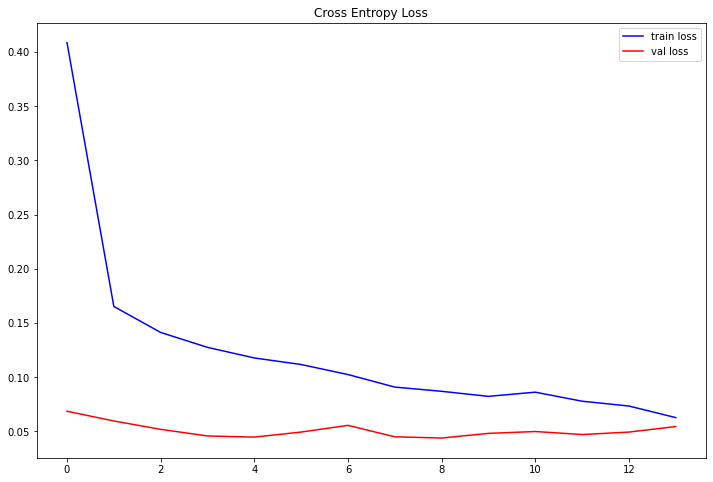

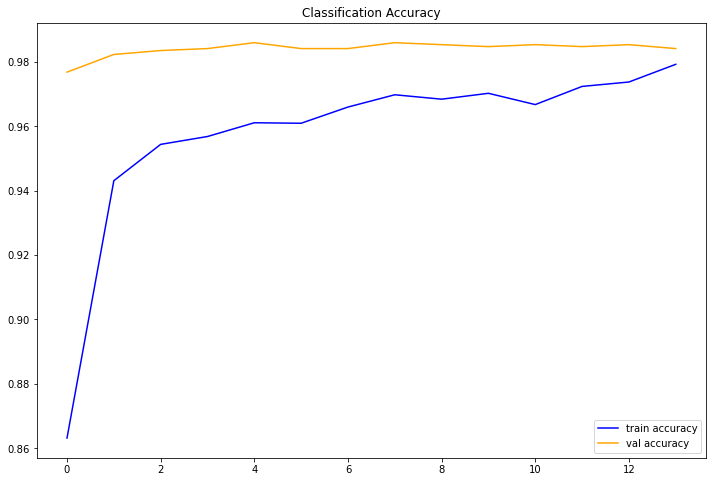

In [21]:
# Madel Diagnostics
summary_diagnostics(history)

### Model Evaluation
- Evaluate the model performance on the Validation Data
    - Generate Confusion Matrix
    - Generate Classification Report

<AxesSubplot:>

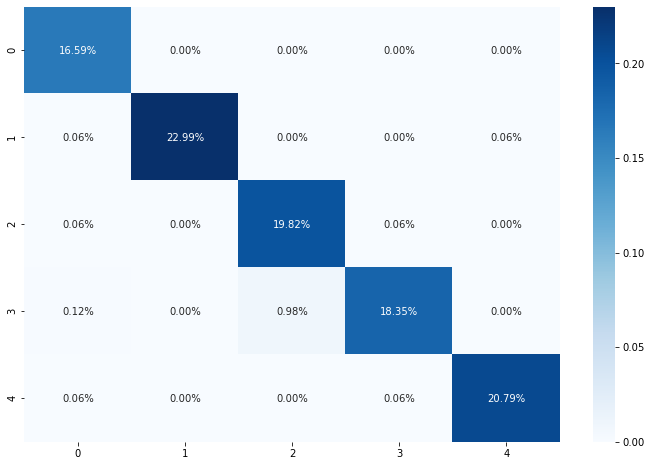

In [22]:
# Confusion Matrix
cf_matrix = confusion_matrix(np.argmax(y_val_cat, axis=1), model.predict_classes(X_val))

plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [23]:
pd.DataFrame(cf_matrix, index=idx_to_class.values(), columns=idx_to_class.values())

,elefante,farfalla,mucca,pecora,scoiattolo
elefante,272,0,0,0,0
farfalla,1,377,0,0,1
mucca,1,0,325,1,0
pecora,2,0,16,301,0
scoiattolo,1,0,0,1,341


In [24]:
print(classification_report(np.argmax(y_val_cat, axis=1), model.predict_classes(X_val)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       272
           1       1.00      0.99      1.00       379
           2       0.95      0.99      0.97       327
           3       0.99      0.94      0.97       319
           4       1.00      0.99      1.00       343

    accuracy                           0.99      1640
   macro avg       0.99      0.99      0.98      1640
weighted avg       0.99      0.99      0.99      1640



#### Comments:
- The model accuracy on the validation dataset was around 99%
- The result indicate that Transfer Learning based CNN Model is far better than simple CNN Model and MLP Model


## TASK 9: Predict
- Generate predictions for test data
- Accuracy on test data: 99.340659%

In [25]:
# Generate predictions for test data
y_predicted = model.predict(X_test)
y_predicted_labels = np.argmax(y_predicted, axis=1)

# Predicted Label Name
y_predicted_labels = [idx_to_class[x] for x in list(y_predicted_labels)]

# Save Prediction Results
test_list = pd.DataFrame()
test_list["target"] = y_predicted_labels
test_list.to_csv("ResNet152V2_results_assignment2.csv", index=False)

In [26]:
# Save Model
model.save("ResNet152v2.h5")